In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


### Uso de OpenCV

In [3]:
# Cargar dataset
DATASET_PATH = r"C:\Users\LENOVO\Documents\GitHub\dataset_planta"

train_dir = os.path.join(DATASET_PATH, "train")
test_dir = os.path.join(DATASET_PATH, "test")

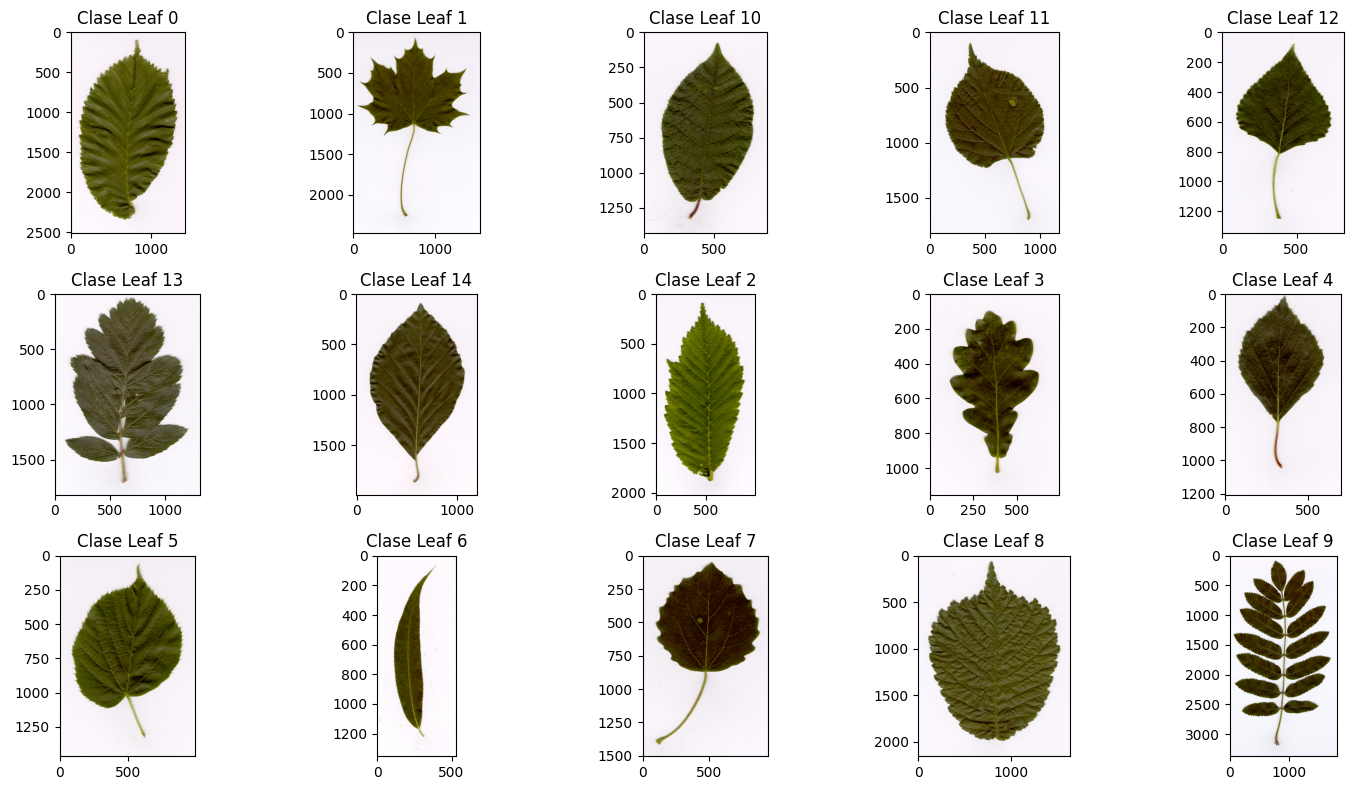

In [4]:
# Lista de carpetas (con las clases)
classes = sorted(os.listdir(train_dir)) #ordenar carpetas

# Mostrar una imagen por clase
plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_name = os.listdir(cls_path)[0]  # tomamos la primera imagen por clase
    img_path = os.path.join(cls_path, img_name)
    
    # Cargar con OpenCV y convertir a RGB
    img = cv2.imread(img_path) #leer la imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #oc lee en RGB
    
    # Mostrar
    plt.subplot(3, 5, i+1)  # 3 filas, 5 columnas (15 especies)
    plt.imshow(img)
    plt.title(f"Clase {cls}")

plt.tight_layout()
plt.show()

### Obtención de parámetros para entrenar un modelo

In [5]:
# Lista para guardar datos
data = []

for label, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        
        # Cargar imagen
        img = cv2.imread(img_path)
        if img is None:
            continue  # saltar archivos inválidos
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Preprocesamiento - llevar a escala de grises
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Contornos
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0: #contorno límite no encontrado
            continue
        cnt = max(contours, key=cv2.contourArea)  #tomar el más grande
        
        # Features
        area = cv2.contourArea(cnt) #Escala del área por pixeles (muy grande)
        perimeter = cv2.arcLength(cnt, True)
        mask = thresh == 255
        mean_color = img_rgb[mask].mean(axis=0)
        
        # Guardar en lista
        data.append({
            "clase": label,
            "area": area,
            "perimetro": perimeter,
            "color_r": mean_color[0],
            "color_g": mean_color[1],
            "color_b": mean_color[2]
        })

# Convertir a DataFrame
df = pd.DataFrame(data)
print(df.head())
df.to_csv("features_hojas.csv", index=False)

   clase       area  perimetro     color_r     color_g     color_b
0      0  3564954.0     7858.0  247.847072  242.194266  247.624401
1      0  2454732.0     6576.0  247.492884  244.806163  250.183767
2      0  2576949.0     6572.0  245.914966  243.549789  249.088281
3      0  3612336.0     7874.0  249.730434  246.792581  251.545727
4      0  1446364.0     4990.0  250.370110  246.403143  251.102829


In [6]:
df.head()

,clase,area,perimetro,color_r,color_g,color_b
0,0,3564954.0,7858.0,247.847072,242.194266,247.624401
1,0,2454732.0,6576.0,247.492884,244.806163,250.183767
2,0,2576949.0,6572.0,245.914966,243.549789,249.088281
3,0,3612336.0,7874.0,249.730434,246.792581,251.545727
4,0,1446364.0,4990.0,250.370110,246.403143,251.102829


In [7]:
df.shape

(1125, 6)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
clase,1125.0,7.000000e+00,4.322415e+00,0.000000,3.000000e+00,7.000000e+00,1.100000e+01,1.400000e+01
area,1125.0,2.030478e+06,1.547256e+06,302064.000000,1.047484e+06,1.602640e+06,2.386845e+06,9.942964e+06
perimetro,1125.0,5.597918e+03,1.874413e+03,2230.000000,4.330000e+03,5.228000e+03,6.344000e+03,1.307000e+04
color_r,1125.0,2.490668e+02,1.840531e+00,240.418486,2.481042e+02,2.493201e+02,2.501971e+02,2.539936e+02
color_g,1125.0,2.452114e+02,1.720316e+00,238.549550,2.442154e+02,2.452128e+02,2.461502e+02,2.535344e+02
color_b,1125.0,2.500096e+02,1.564183e+00,244.168630,2.490989e+02,2.501100e+02,2.510644e+02,2.540358e+02


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   clase      1125 non-null   int64  
 1   area       1125 non-null   float64
 2   perimetro  1125 non-null   float64
 3   color_r    1125 non-null   float64
 4   color_g    1125 non-null   float64
 5   color_b    1125 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 52.9 KB


### Partición y análisis con Modelos básicos

In [10]:
#Partición de datos
X = df.drop("clase", axis=1)
y = df["clase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Comentario: mantener proporciones de cada tipo de planta en la partición (stratify)

## Escalado de datos para modelos susceptibles (KNN y RandomForest)

In [11]:
#Escalado con StandardScaler para llevarlos a una media 0 y desviación estándar 1 (mas o menos misma escala)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Entrenamiento y Modelado - RandomForest

Empezaré entrenamiento con un RandomForest porque es más robusto con datasets con un número reducido de características. Además, al combinar múltiples árboles, permite capturar relaciones no lineales y diversas combinaciones de rasgos de las hojas que ayudan a mejorar el poder de clasificación frente a otros modelos un poco más simples.

In [12]:
#Entrenamiento e inicialización del modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42) #por default

#Cross-validation (evitar única partición)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy por fold:", cv_scores)
print("Accuracy promedio:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Accuracy por fold: [0.48888889 0.44444444 0.46111111 0.35555556 0.44444444]
Accuracy promedio: 0.43888888888888894
Desviación estándar: 0.04472135954999579


In [13]:
# Entrenar en todo el set de entrenamiento
clf.fit(X_train, y_train)

# Predecir en test
y_pred = clf.predict(X_test)

# Métricas finales
print("\nAccuracy en test:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy en test: 0.44

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.20      0.19        15
           1       0.75      0.60      0.67        15
           2       0.36      0.27      0.31        15
           3       0.29      0.27      0.28        15
           4       0.31      0.27      0.29        15
           5       0.19      0.27      0.22        15
           6       0.33      0.40      0.36        15
           7       0.27      0.20      0.23        15
           8       0.33      0.33      0.33        15
           9       0.67      0.93      0.78        15
          10       0.75      0.60      0.67        15
          11       0.86      0.80      0.83        15
          12       0.27      0.20      0.23        15
          13       0.32      0.40      0.35        15
          14       0.76      0.87      0.81        15

    accuracy                           0.44       225
   macro avg       0.44      0.

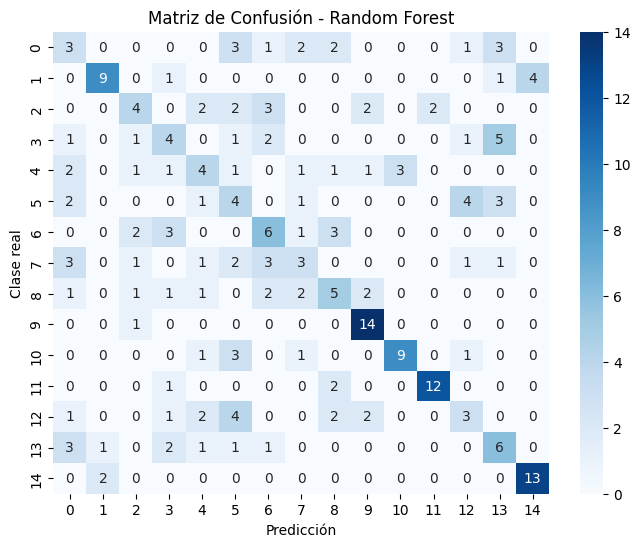

In [14]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

##### Comentario: interesante ver que la diagonal tiene muy bajos valores propios identificables del mismo grupo de plantas. No está identificando correctamente.

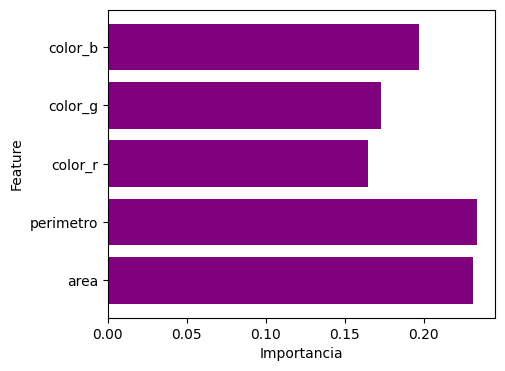

In [30]:
#Importancia de las caracteríticas para el modelo
importances = clf.feature_importances_
features = X.columns

plt.figure(figsize=(5,4))
plt.barh(features, importances, color='purple')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()

**Comentario**: Aparentemente, la característica de mayor importancia para la clasificación a partir de las hojas es el área y perímetro.

### **Comparación con KNN - method**

k=3: Accuracy promedio = 0.3644
k=5: Accuracy promedio = 0.3633
k=7: Accuracy promedio = 0.3811
k=9: Accuracy promedio = 0.3900
k=11: Accuracy promedio = 0.3867


Text(0.5, 1.0, 'Evaluación de KNN')

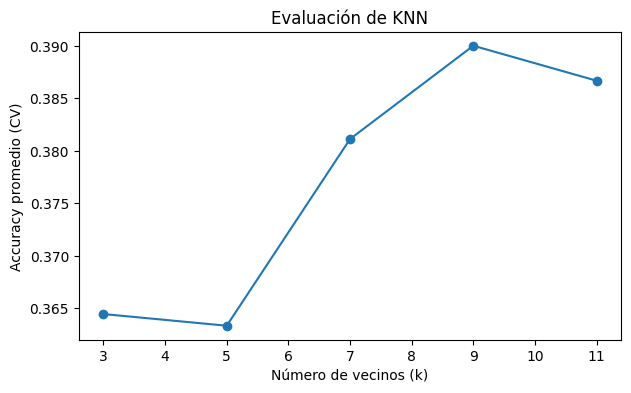

In [18]:
# Probamos varios valores de k
k_values = [3, 5, 7, 9, 11]
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    mean_scores.append(scores.mean())
    print(f"k={k}: Accuracy promedio = {scores.mean():.4f}")

# Graficar resultados
plt.figure(figsize=(7,4))
plt.plot(k_values, mean_scores, marker='o')
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Accuracy promedio (CV)")
plt.title("Evaluación de KNN")

#### **Elegir el mejor k para KNN**

In [19]:
# Elegir el mejor k
best_k = k_values[np.argmax(mean_scores)]
print(f"Mejor valor de k: {best_k}")

# Entrenar con el mejor k y evaluar en test
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)

print("\nAccuracy en test (KNN):", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

Mejor valor de k: 9

Accuracy en test (KNN): 0.4266666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.20      0.17        15
           1       0.77      0.67      0.71        15
           2       0.41      0.47      0.44        15
           3       0.24      0.27      0.25        15
           4       0.19      0.27      0.22        15
           5       0.17      0.20      0.18        15
           6       0.35      0.47      0.40        15
           7       0.18      0.13      0.15        15
           8       0.56      0.33      0.42        15
           9       0.75      1.00      0.86        15
          10       1.00      0.60      0.75        15
          11       0.62      0.53      0.57        15
          12       0.00      0.00      0.00        15
          13       0.36      0.33      0.34        15
          14       0.82      0.93      0.88        15

    accuracy                           0.43  

##### *Comentario* : No existe mucha diferencia en los niveles de Accuracy entre RF y KNN, intentaremos optimizar los parámetros de RF. 

## Optimización de parámetros en RandomForest

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                    cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print("Mejores parámetros encontrados:")
print(grid.best_params_)

mejor_modelo = grid.best_estimator_
y_pred_opt = mejor_modelo.predict(X_test_scaled)

print("\nAccuracy optimizado:", accuracy_score(y_test, y_pred_opt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Accuracy optimizado: 0.4444444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.20      0.20        15
           1       0.69      0.60      0.64        15
           2       0.33      0.33      0.33        15
           3       0.24      0.27      0.25        15
           4       0.27      0.20      0.23        15
           5       0.14      0.20      0.17        15
           6       0.33      0.33      0.33        15
           7       0.43      0.40      0.41        15
           8       0.38      0.33      0.36        15
           9       0.70      0.93      0.80        15
          10       0.77      0.67      0.71        15
          11       0.80      0.80      0.80        15
          12       0.33      0.20      0.25       

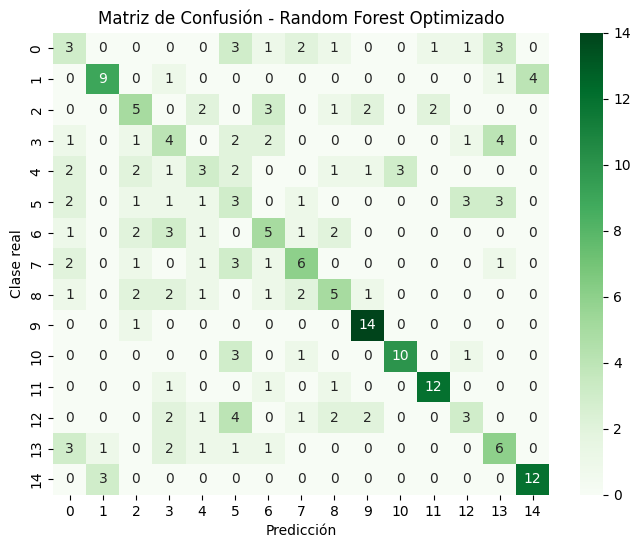

In [22]:
# Matriz de confusión del modelo optimizado
cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(8,6))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

##### **Comentario**: Está más que claro que el modelo necesita más características para poder clasificar correctamente las hojas de cada especie. Éstas por si solas, no están clasificando bien las especies. 

,clase,area,perimetro,color_r,color_g,color_b
0,0,3564954.0,7858.0,247.847072,242.194266,247.624401
1,0,2454732.0,6576.0,247.492884,244.806163,250.183767
2,0,2576949.0,6572.0,245.914966,243.549789,249.088281
3,0,3612336.0,7874.0,249.730434,246.792581,251.545727
4,0,1446364.0,4990.0,250.370110,246.403143,251.102829
